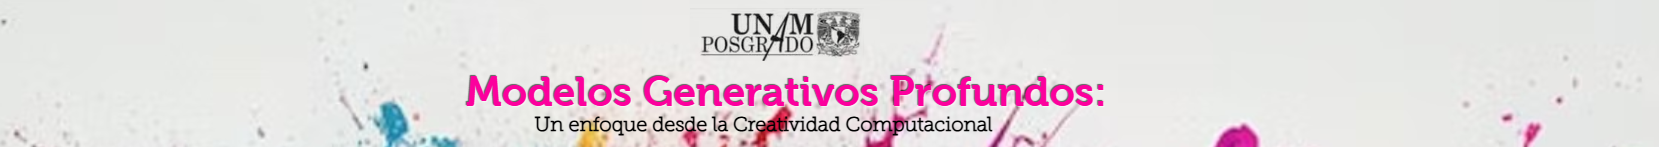

# Autocodificadores Variacionales - CelebA Faces

En este cuaderno recorreremos los pasos necesarios para entrenar tu propio autoencoder variacional en el conjunto de datos de rostros CelebA.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/CursoIAGenerativa/')
sys.path.append('/content/drive/My Drive/Colab Notebooks/CursoIAGenerativa/notebooks/Clase10_autoencoders/')


import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

from notebooks.utils import sample_batch, display
from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0. Parámetros  

In [ ]:
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

## 1. Preparar los datos

Descargando CelebA (esto puede tardar unos minutos la primera vez)...
Shape del batch: (128, 64, 64, 3)


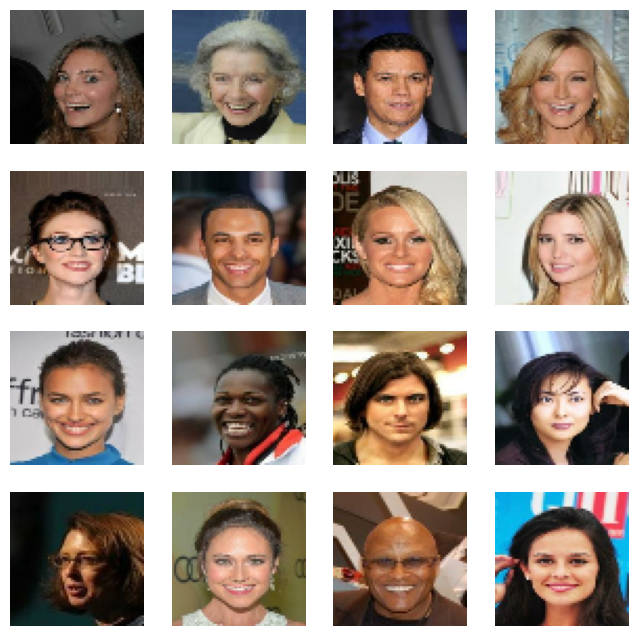

In [ ]:
# ================================
# 2. Importar librerías
# ================================
import tensorflow as tf
import tensorflow_datasets as tfds

# ================================
# 3. Hiperparámetros
# ================================
IMAGE_SIZE = 64
BATCH_SIZE = 128
BUFFER_SIZE = 1000

# ================================
# 4. Cargar el dataset CelebA
# ================================
print("Descargando CelebA (esto puede tardar unos minutos la primera vez)...")
ds_train = tfds.load("celeb_a", split="train")

# ================================
# 5. Preprocesamiento
# ================================
def preprocess(example):
    img = example["image"]
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Redimensionar
    img = tf.cast(img, tf.float32) / 255.0                # Normalizar a [0,1]
    return img

# Aplicar preprocesamiento, mezclar, agrupar en batches
train = ds_train.map(preprocess).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ================================
# 6. Verificar dataset
# ================================
for batch in train.take(1):
    print("Shape del batch:", batch.shape)

# Mostrar algunas imágenes para confirmar
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for i, img in enumerate(batch[:16]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.show()


In [ ]:
train_sample = sample_batch(train)

## 2. Construir el autocodificador variacional

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Codificador
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      3,584 │ encoder_input[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │    147,584 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 128) │    147,584 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 4, 4, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 200)       │    409,800 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 200)       │    409,800 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 200)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,267,984 (4.84 MB)

 Trainable params: 1,266,960 (4.83 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# Decodificador
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │       411,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 3)      │         3,459 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,015,683 (3.87 MB)

 Trainable params: 1,010,563 (3.85 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [ ]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
        self.mse_loss = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Llama el modelo con una entrada en particular """
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Paso de ejecución durante el entrenamiento """
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            # Error de reconstrucción (MSE)
            reconstruction_loss = BETA * self.mse_loss(data, reconstruction)
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Paso de ejecución durante la validación """
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
# Crea el autocodificar variacional
vae = VAE(encoder, decoder)

## 3. Entrenar el VAE

In [ ]:
# Compilar el VAE
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [ ]:
import os

# Crear un modelo y salvar el checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim, output_dir="./output"):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)  # crear la carpeta

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images = tf.cast(generated_images, tf.uint8).numpy()

        for i in range(self.num_img):
            img = tf.keras.utils.array_to_img(generated_images[i])
            img.save(os.path.join(self.output_dir, f"generated_img_{epoch:03d}_{i}.png"))

In [ ]:
# Cargar los pesos generados anteriormente si se requiere
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

In [ ]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)


Epoch 1/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 140s 110ms/step - kl_loss: 17.8479 - loss: 69.2553 - reconstruction_loss: 51.4074
Epoch 2/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 141s 110ms/step - kl_loss: 17.9448 - loss: 67.0625 - reconstruction_loss: 49.1177
Epoch 3/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 139s 109ms/step - kl_loss: 18.0121 - loss: 66.1133 - reconstruction_loss: 48.1012
Epoch 4/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 142s 109ms/step - kl_loss: 18.1906 - loss: 65.5730 - reconstruction_loss: 47.3824
Epoch 5/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 142s 109ms/step - kl_loss: 18.2016 - loss: 64.9982 - reconstruction_loss: 46.7965
Epoch 6/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 142s 109ms/step - kl_loss: 18.2075 - loss: 64.7435 - reconstruction_loss: 46.5361
Epoch 7/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 139s 109ms/step - kl_loss: 18.2487 - loss: 64.5271 - reconstruction_loss: 46.2784
Epoch 8/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 142s 109ms/step - kl_loss: 18.2475 - loss: 64.2291 - reconstruction_loss: 45.9817
Epoch 9/

In [ ]:
import os

# Crear la carpeta si no existe
os.makedirs("./models", exist_ok=True)


# Salvar los modelos finales
vae.save("./models/vae.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

# Para cargarlo después puedes usar:
#from keras.models import load_model
#vae = load_model("./models/vae.keras")
#encoder = load_model("./models/encoder.keras")
#decoder = load_model("./models/decoder.keras")

In [ ]:
# Descargar los modelos
from google.colab import files

files.download("./models/vae.keras")
files.download("./models/encoder.keras")
files.download("./models/decoder.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. Reconstruir usando el VAE

In [ ]:
# Selecciona un subconjunto del conjunto de prueba
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

In [1]:
# Crear predicciones del autocodificador y las despliega
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

NameError: name 'vae' is not defined

## 4. Distribucón del espacio latente

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


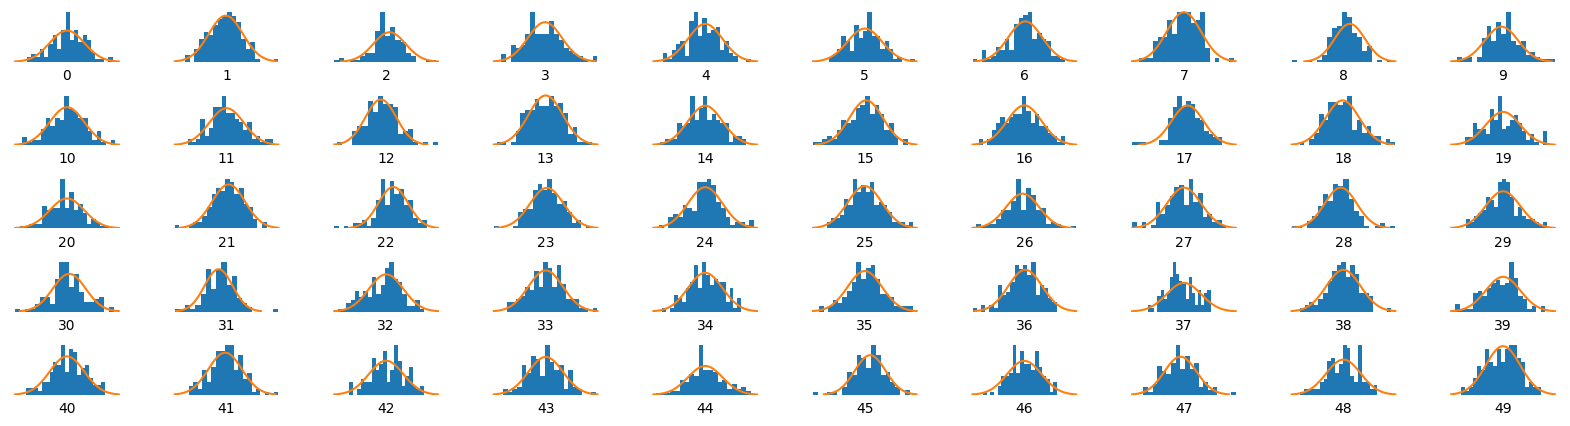

In [ ]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

## 5. Generar nuevos rostros

In [ ]:
# Muestrear algunos puntos en el espacio latente, de la distribución normal estándard
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decodificar los puntos muestreados
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


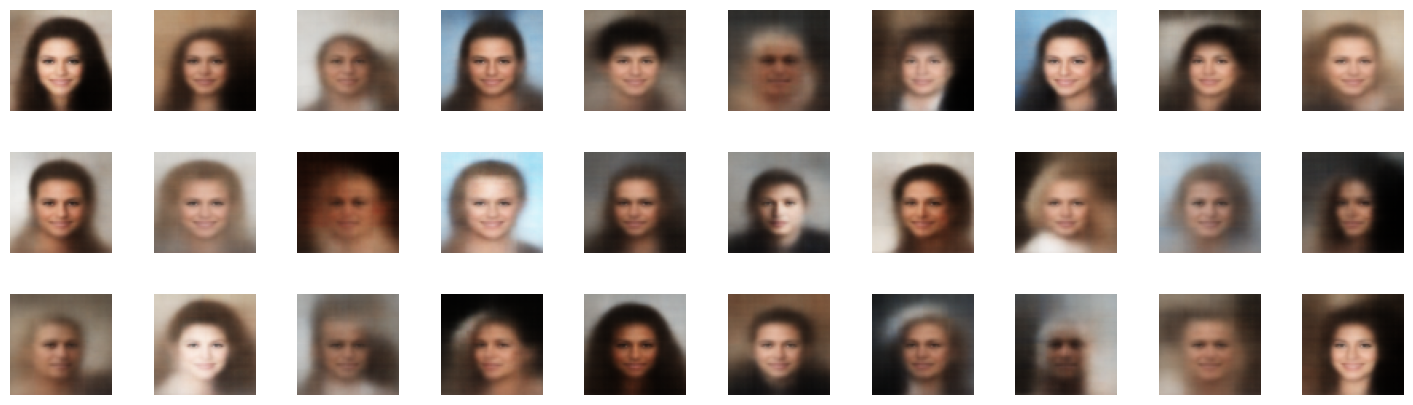

In [ ]:
# Dibuja un plot de las imágenes decodificadas
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Muestra la malla con las imágenes
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

## 6. Manipulación de las imágenes

In [ ]:
def get_vector_from_label2(data, vae, embedding_dim, label):
    pos_embeddings, neg_embeddings = [], []

    for x, y in data:
        z_mean, _, _ = vae.encoder(x)  # asumiendo encoder devuelve (mu, logvar, z)
        z_mean = z_mean.numpy()

        for zi, li in zip(z_mean, y.numpy()):
            if li == 1:
                pos_embeddings.append(zi)
            else:
                neg_embeddings.append(zi)

    if len(pos_embeddings) == 0 or len(neg_embeddings) == 0:
        raise ValueError(f"No hay suficientes positivos/negativos para {label}")

    new_mean_POS = np.mean(pos_embeddings, axis=0)
    new_mean_NEG = np.mean(neg_embeddings, axis=0)

    return new_mean_POS - new_mean_NEG

Atributos disponibles: ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
Distribución de etiquetas: {0: np.int64(5463), 1: np.int64(937)}


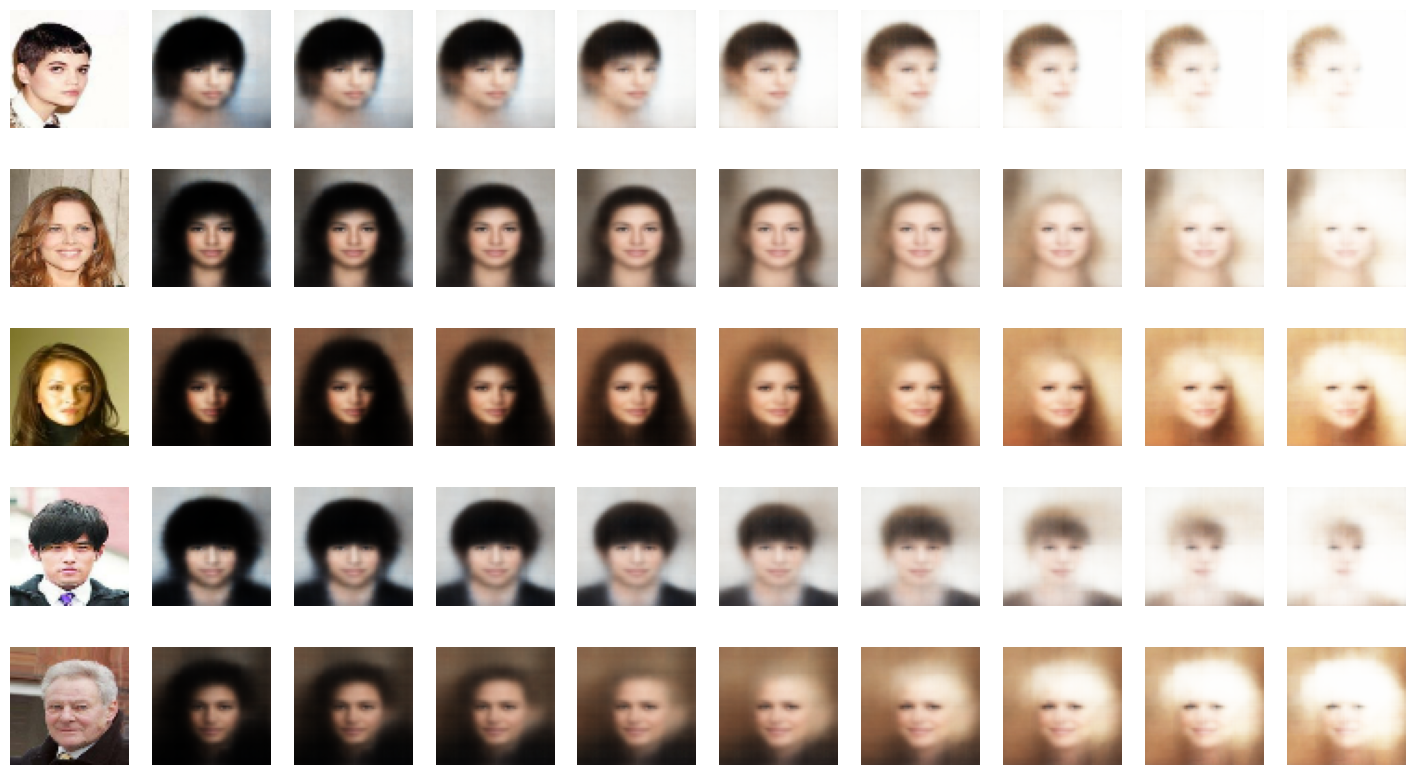

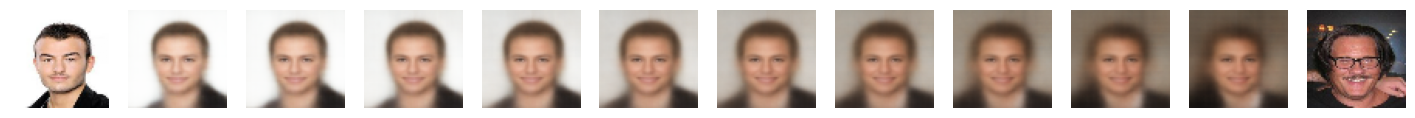

In [ ]:
# Solo para inspeccionar las columnas disponibles (como antes con attributes.columns)
first_example = next(iter(ds_train))
print("Atributos disponibles:", list(first_example["attributes"].keys()))

# ====================================================
# 2. Seleccionar un atributo
# ====================================================
LABEL = "Blond_Hair"   # <- El atributo que quieres
IMAGE_SIZE = 64        # ajusta a tu valor
BATCH_SIZE = 32        # ajusta a tu valor

def preprocess_image(example):
    image = tf.image.resize(example["image"], (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(example["attributes"][LABEL], tf.int32)
    return image, label

# ====================================================
# 3. Crear dataset con imágenes + etiquetas
# ====================================================
# División train/validation (ejemplo 80/20)
n_total = ds_train.cardinality().numpy()
n_val = int(n_total * 0.2)

ds = ds_train.shuffle(10000, seed=42)
val_ds = ds.take(n_val).map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_ds = ds.skip(n_val).map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ====================================================
# 4. Usar en tus funciones existentes
# ====================================================
# Aquí sustituyes labelled_test y labelled
labelled_test = train_ds
labelled = labelled_test.map(lambda x, y: (x, y))  # preprocess ya aplicado

counts = {0: 0, 1: 0}
for _, y in labelled.take(200):   # revisar primeras 200 batches
    vals, freqs = np.unique(y.numpy(), return_counts=True)
    for v, f in zip(vals, freqs):
        counts[v] += f

print("Distribución de etiquetas:", counts)

# Ahora puedes usar tu pipeline como antes
attribute_vec = get_vector_from_label2(labelled, vae, Z_DIM, LABEL)
add_vector_to_images(labelled, vae, attribute_vec)
morph_faces(labelled, vae)